# 3D Gene Expression Pattern

This notebook demonstrates the 3D Gene Expression Pattern. This is done in the following three steps.
1. 3D Gene Expression Pattern in original point cloud model；
2. Interpolated 3D Gene Expression Pattern in volume models based on the interpolation kernel;
3. Interpolated 3D Gene Expression Pattern in volume models based on deep learning.

### Packages

In [48]:
import os
import anndata as ad
import numpy as np
import spateo as st

In [49]:
### Data source

In [50]:
h5ad_file = r"/media/yao/Yao/Projects/Project_spateo/Data/E8-10_b_sample/5_annotation/E8-10_b_all_anno_scsq.h5ad"
pc_file = f"/media/yao/Yao/Projects/Project_spateo/Data/E8-10_b_sample/6_three_dims_reconstruction/E8-10_b_all_anno_scsq/1_reconstruct_whole_body/mesh/trim_pc_model.vtk"
volume_file = f"/media/yao/Yao/Projects/Project_spateo/Data/E8-10_b_sample/6_three_dims_reconstruction/E8-10_b_all_anno_scsq/1_reconstruct_whole_body/mesh/volume_model.vtk"

adata = ad.read_h5ad(h5ad_file)
pc = st.tdr.read_mesh(pc_file)
volume = st.tdr.read_mesh(volume_file)
########################################################################################################################
save_folder = r"/media/yao/Yao/Projects/Project_spateo/Data/E8-10_b_sample/6_three_dims_reconstruction"
save_cellbin_tdr_folder = os.path.join(save_folder, r"E8-10_b_all_anno_scsq")
save_cellbin_tdr_4_folder = os.path.join(save_cellbin_tdr_folder, r"4_gene_expression_patterns")
save_cellbin_tdr_mesh_folder = os.path.join(save_cellbin_tdr_4_folder, r"mesh")
save_cellbin_tdr_image_folder = os.path.join(save_cellbin_tdr_4_folder, r"image")
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
if not os.path.exists(save_cellbin_tdr_folder):
    os.mkdir(save_cellbin_tdr_folder)
if not os.path.exists(save_cellbin_tdr_4_folder):
    os.mkdir(save_cellbin_tdr_4_folder)
if not os.path.exists(save_cellbin_tdr_mesh_folder):
    os.mkdir(save_cellbin_tdr_mesh_folder)
if not os.path.exists(save_cellbin_tdr_image_folder):
    os.mkdir(save_cellbin_tdr_image_folder)

### 3D Gene Expression Pattern in original point cloud model

#### Add original gene expression info to the point cloud model

In [51]:
marker_genes = ["Act57B", "Act87E", "Mef2", "betaTub60D", "Obp99a", "Cys", "sala", "HmgD", "Df31",
                "Bacc", "cpo", "cato", "elav", "ed", "CG12011", "nur", "CG13159", "PPO1", "PPO1"]

for marker_gene in marker_genes:
    obs_index = pc.point_data["obs_index"].tolist()
    sub_adata = adata[obs_index, marker_gene]
    mkg_exp = sub_adata.X.flatten().astype(np.float64)

    mkg_exp_adj = mkg_exp.copy()
    mkg_exp_adj[mkg_exp_adj <= 0] = 0

    mkg_amap = mkg_exp.copy()
    mkg_amap = mkg_amap - mkg_amap.min()
    mkg_amap = mkg_amap / mkg_amap.max()
    mkg_amap[mkg_amap <= 0.1] = 0.1

    st.tdr.add_mesh_labels(mesh=pc, labels=mkg_exp_adj, key_added=marker_gene, where="point_data", colormap="Purples", alphamap=mkg_amap)

print(pc.point_data)

pyvista DataSetAttributes
Association     : POINT
Active Scalars  : PPO1_rgba
Active Vectors  : None
Active Texture  : None
Active Normals  : None
Contains arrays :
    groups_rgba             float64  (12479, 4)
    groups                  <U25     (12479,)
    obs_index               <U15     (12479,)
    area                    int64    (12479,)
    area_rgba               float64  (12479, 4)
    Act57B                  float64  (12479,)
    Act57B_rgba             float64  (12479, 4)
    Act87E                  float64  (12479,)
    Act87E_rgba             float64  (12479, 4)
    Mef2                    float64  (12479,)
    Mef2_rgba               float64  (12479, 4)
    betaTub60D              float64  (12479,)
    betaTub60D_rgba         float64  (12479, 4)
    Obp99a                  float64  (12479,)
    Obp99a_rgba             float64  (12479, 4)
    Cys                     float64  (12479,)
    Cys_rgba                float64  (12479, 4)
    sala                    float64  

#### Visualization

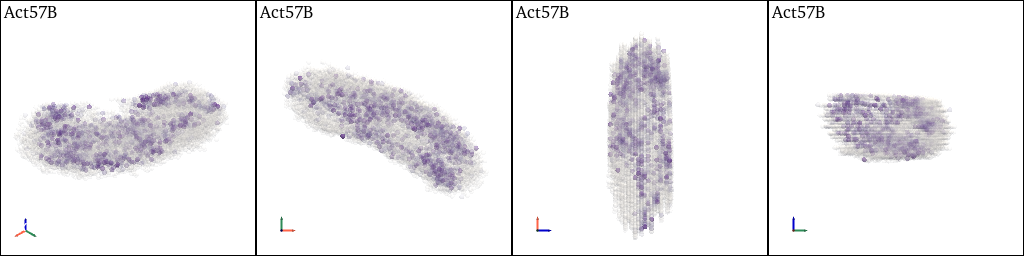

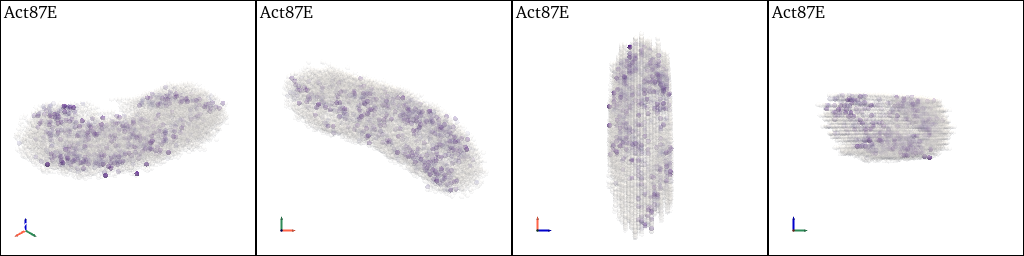

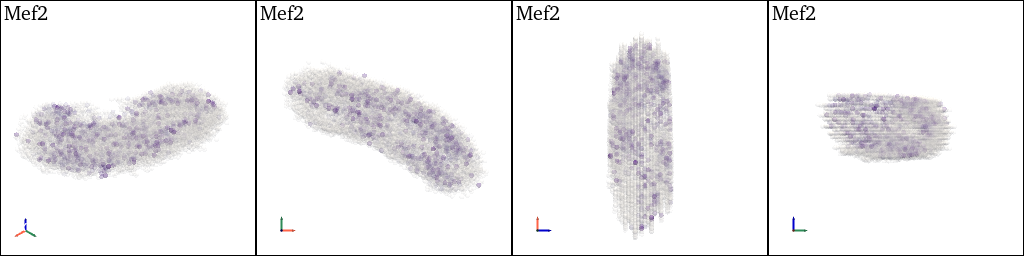

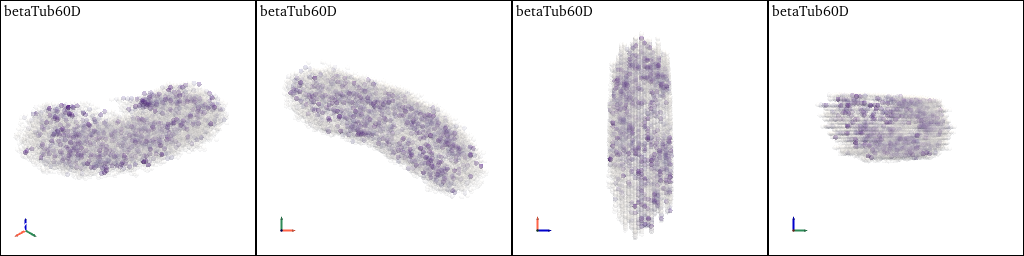

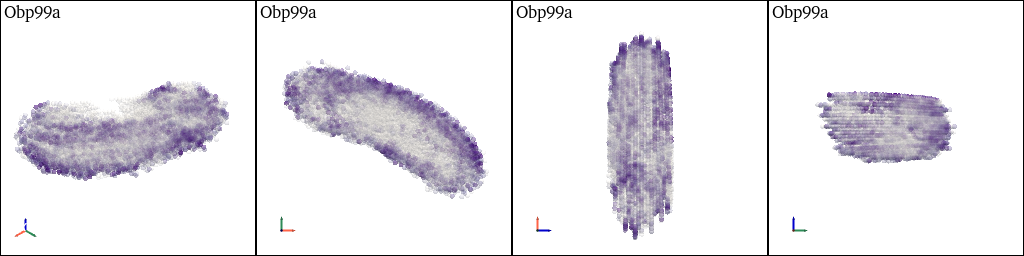

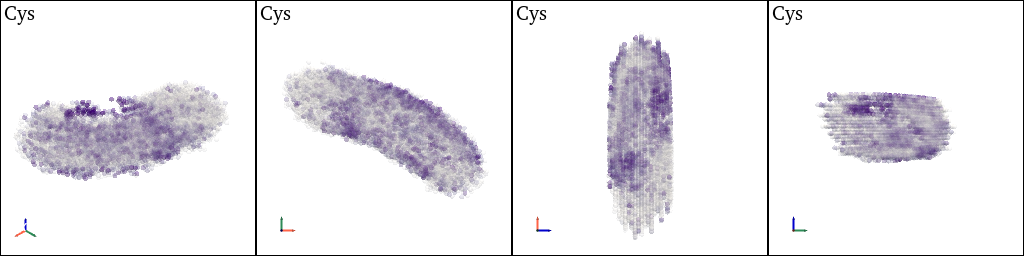

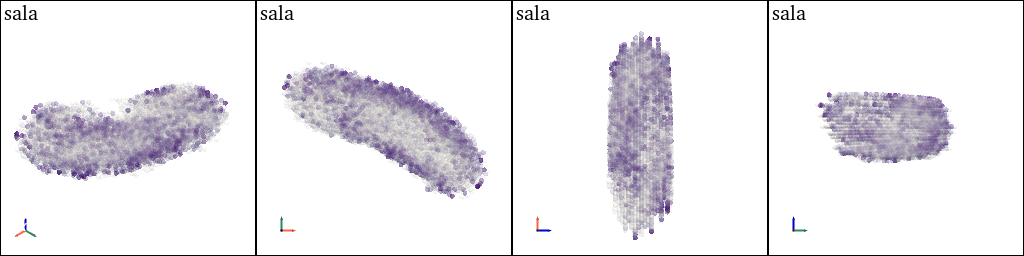

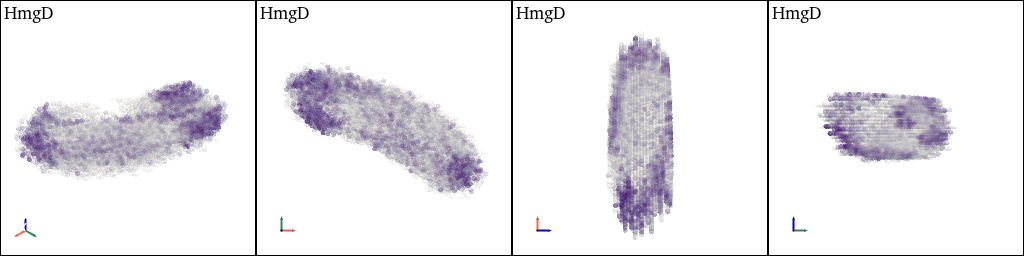

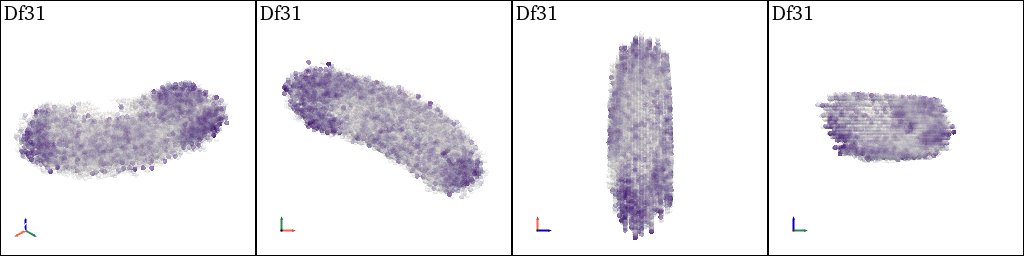

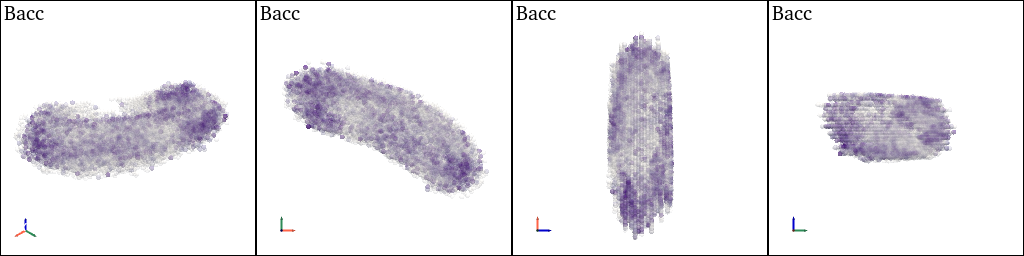

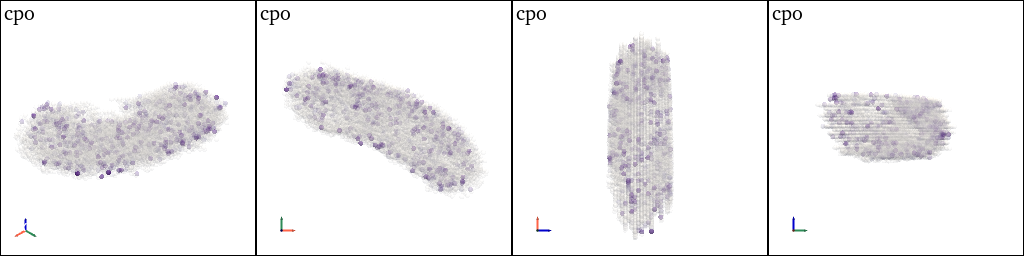

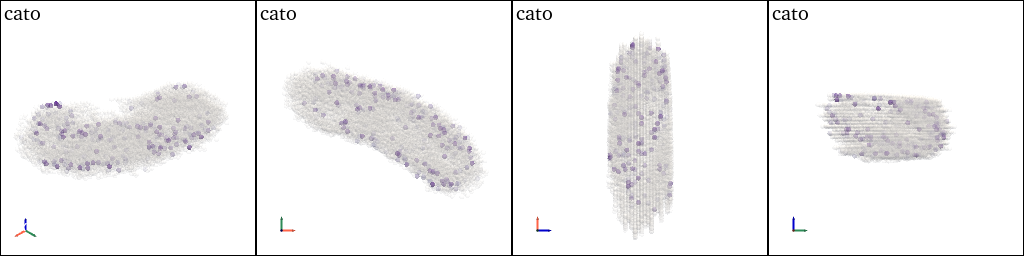

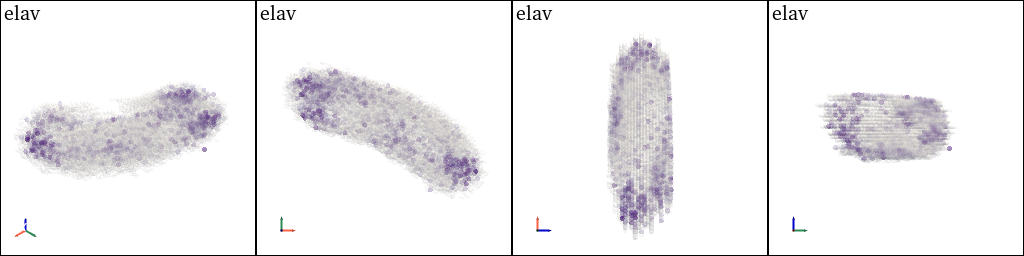

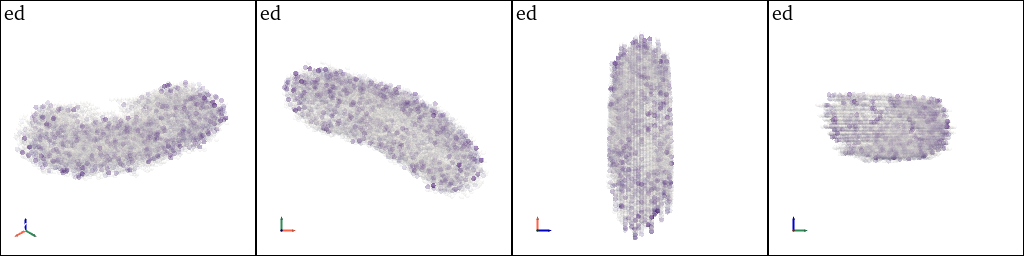

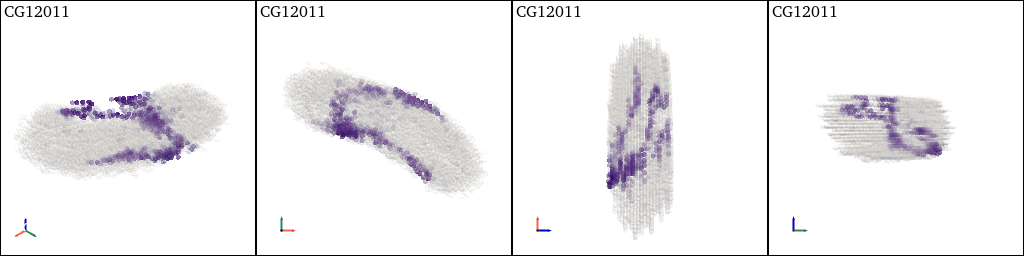

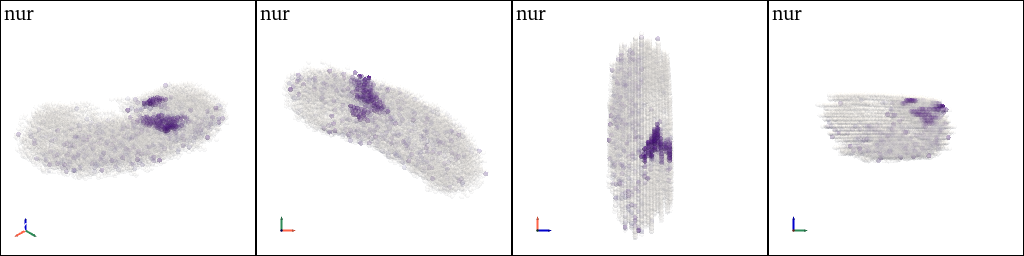

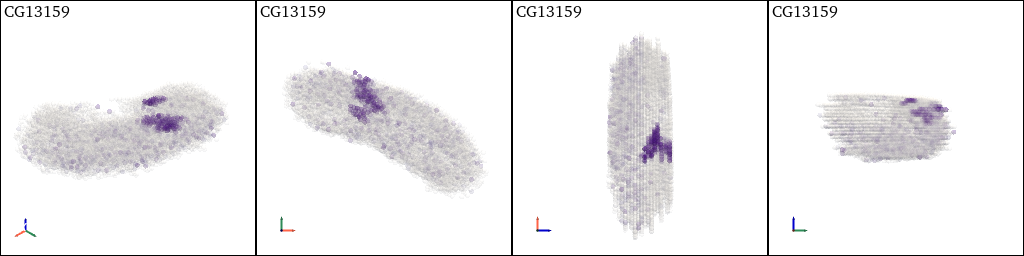

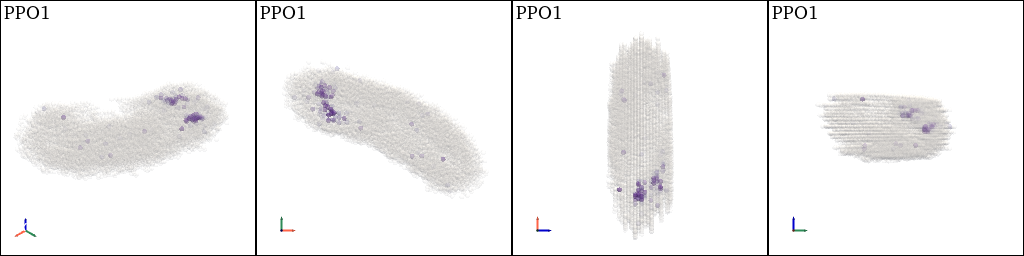

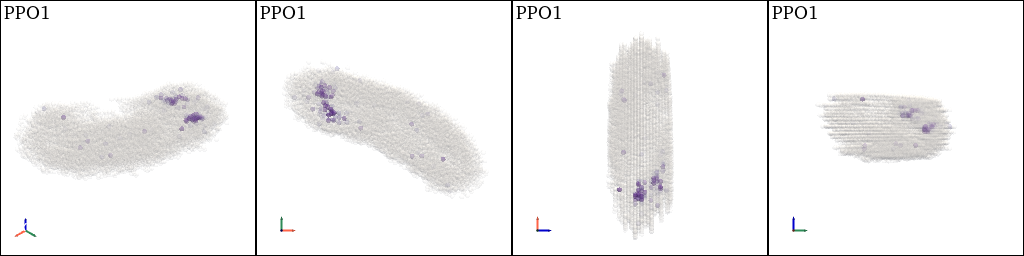

In [52]:
def visualization(mesh, gene_name, jupyter=False, save_image=None):
    p = st.pl.create_plotter(jupyter=jupyter, background="white", shape=(1, 4), window_size=(1024, 256))
    for i, cpo in enumerate(["iso", "xy", "zx", "yz"]):
        p.subplot(0, i)
        st.pl.add_mesh(plotter=p, mesh=mesh, key=gene_name)
        p.add_axes()
        p.add_text(gene_name, color="black", font_size=8, font="times")
        p.camera_position = cpo
    st.pl.output_plotter(p=p, filename=save_image, jupyter=jupyter)

for marker_gene in marker_genes:
    visualization(pc, gene_name=marker_gene, jupyter=True, save_image=None)
    visualization(pc, gene_name=marker_gene, jupyter=False, save_image=os.path.join(save_cellbin_tdr_image_folder, f"{marker_gene}_pc.tiff"))

### Interpolated 3D Gene Expression Pattern in volume models based on the interpolation kernel

#### Use shepard kernel

vtkShepardKernel is an interpolation kernel that uses the method of Shepard to perform interpolation. The weights are computed as 1/r^p, where r is the distance to
a neighbor point within the kernel radius R; and p (the power parameter) is a positive exponent (typically p=2).

pyvista DataSetAttributes
Association     : POINT
Active Scalars  : PPO1_rgba
Active Vectors  : None
Active Texture  : None
Active Normals  : None
Contains arrays :
    groups_rgba             float64  (1314738, 4)
    area                    float32  (1314738,)
    area_rgba               float64  (1314738, 4)
    Act57B                  float64  (1314738,)
    Act57B_rgba             float64  (1314738, 4)
    Act87E                  float64  (1314738,)
    Act87E_rgba             float64  (1314738, 4)
    Mef2                    float64  (1314738,)
    Mef2_rgba               float64  (1314738, 4)
    betaTub60D              float64  (1314738,)
    betaTub60D_rgba         float64  (1314738, 4)
    Obp99a                  float64  (1314738,)
    Obp99a_rgba             float64  (1314738, 4)
    Cys                     float64  (1314738,)
    Cys_rgba                float64  (1314738, 4)
    sala                    float64  (1314738,)
    sala_rgba               float64  (1314738, 4)
 

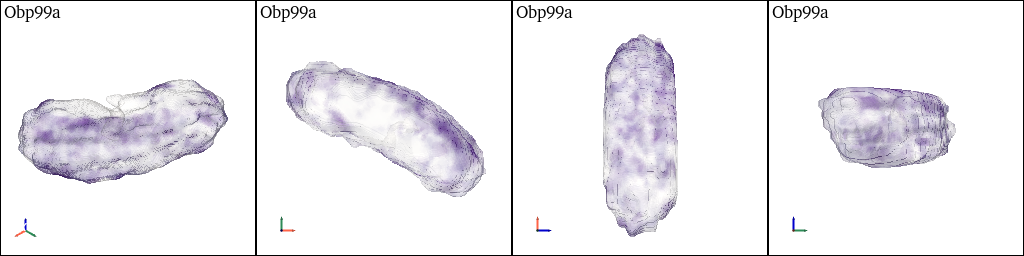

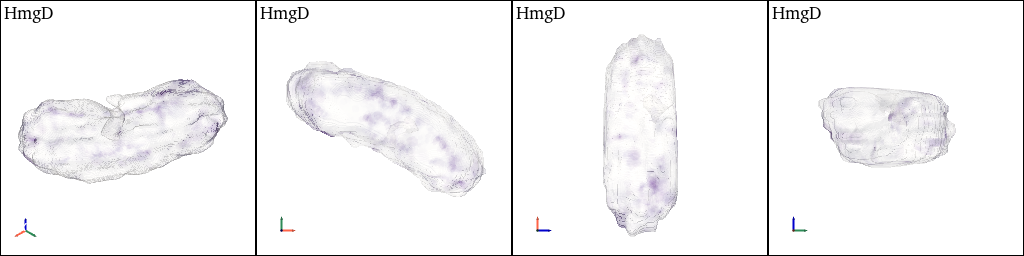

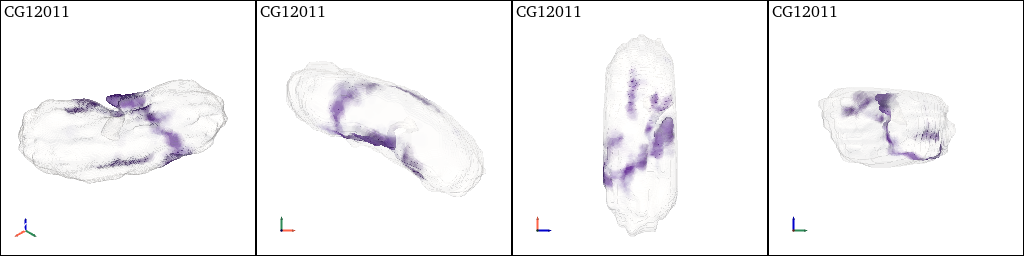

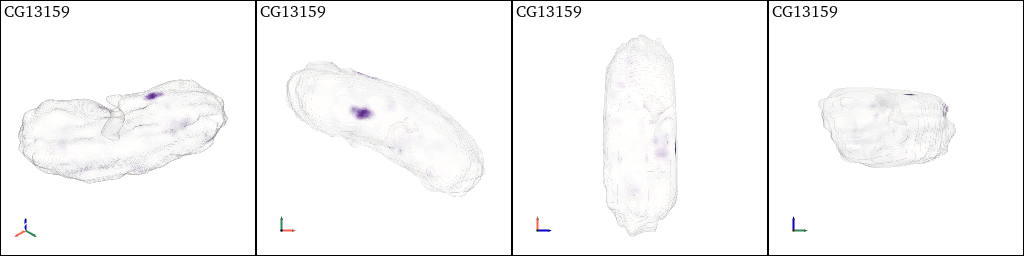

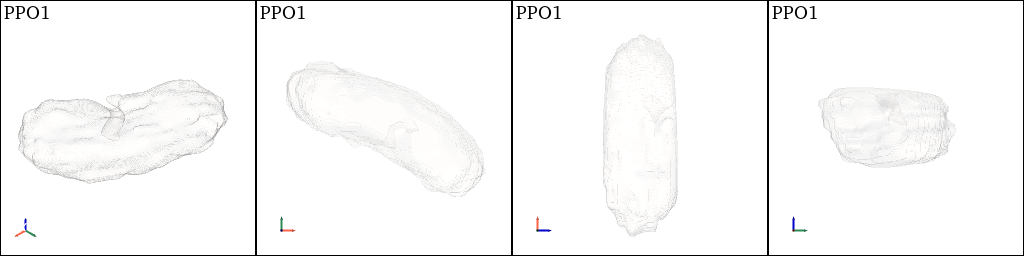

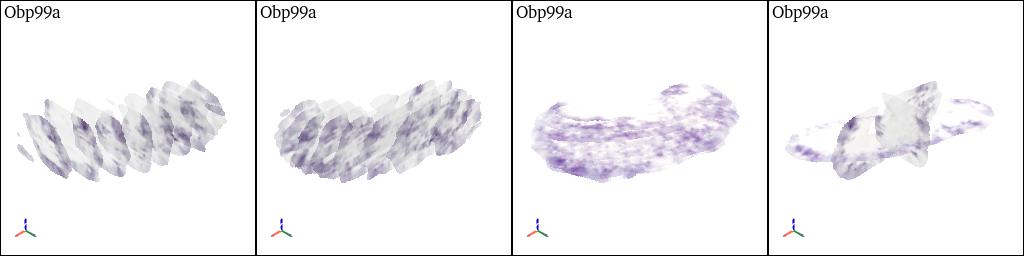

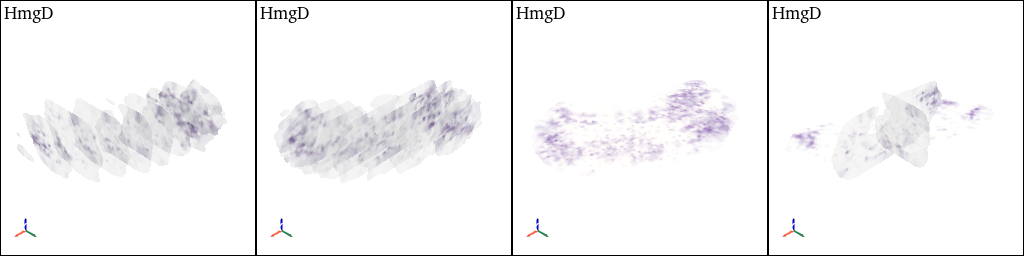

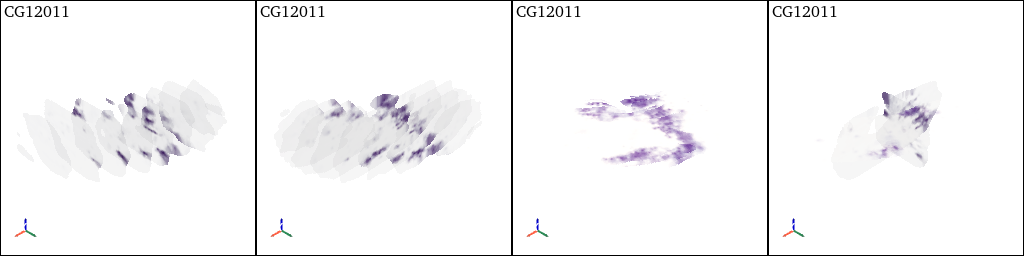

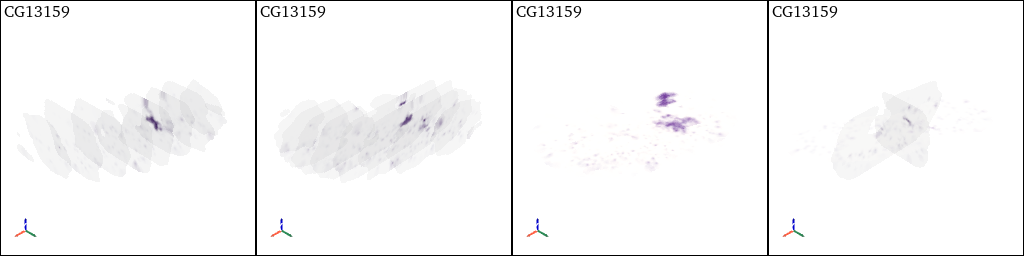

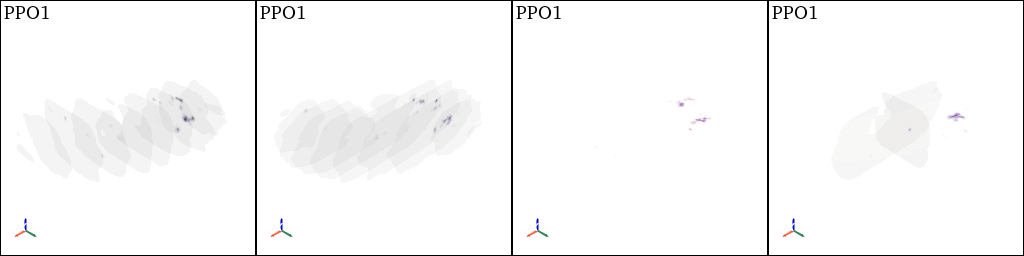

In [53]:
def visualization_slicing(sliceing_models, gene_name, jupyter=False, save_image=None):
    p = st.pl.create_plotter(jupyter=jupyter, background="white", shape=(1, 4), window_size=(1024, 256))
    for i, model in enumerate(sliceing_models):
        p.subplot(0, i)
        st.pl.add_mesh(plotter=p, mesh=model, key=gene_name)
        p.add_text(gene_name, color="black", font_size=8, font="times")
        p.add_axes()
        p.camera_position = "iso"
    st.pl.output_plotter(p=p, filename=save_image, jupyter=jupyter)


source_pc = pc.copy()
del source_pc.point_data["obs_index"], source_pc.point_data["groups"]
interpolated_volume = st.tdr.interpolate_mesh(mesh=volume, source=source_pc, N=5, where="point_data", kernel="shepard")
print(interpolated_volume.point_data)

for marker_gene in ["Obp99a", "HmgD", "CG12011", "CG13159", "PPO1"]:
    visualization(interpolated_volume, gene_name=marker_gene, jupyter=True, save_image=None)
    visualization(interpolated_volume, gene_name=marker_gene, jupyter=False,
                  save_image=os.path.join(save_cellbin_tdr_image_folder, f"{marker_gene}_interpolated_kernel.tiff"))

# slicing
slices_models = [
    st.tdr.three_d_slice(mesh=interpolated_volume, axis="x", n_slices=10, method="axis"),
    st.tdr.three_d_slice(mesh=interpolated_volume, axis="y", n_slices=10, method="axis"),
    st.tdr.three_d_slice(mesh=interpolated_volume, axis="z", n_slices=10, method="axis"),
    st.tdr.three_d_slice(mesh=interpolated_volume, method="orthogonal"),
]

for marker_gene in ["Obp99a", "HmgD", "CG12011", "CG13159", "PPO1"]:
    visualization_slicing(sliceing_models=slices_models, gene_name=marker_gene, jupyter=True)
    visualization_slicing(sliceing_models=slices_models, gene_name=marker_gene, jupyter=False,
                          save_image=os.path.join(save_cellbin_tdr_image_folder, f"{marker_gene}_interpolated_kernel_slicing.tiff"))

### Interpolated 3D Gene Expression Pattern in volume models based on deep learning

See deep interpolate.